In [147]:
# LSEG/Refinitive Data Acquisition of Required Data
#Target Period: 2006-01-01 to 2025-06-30

#Imports
#Import Refinitiv data library for data acquisition
import pandas as pd
import numpy as np
import yfinance as yf

In [149]:
#Define instruments and Date range
start = "2006-01-01"
end = "2025-06-30"

# S&P500 ETF (proxy)
df_spx_raw = yf.download("SPY", start=start, end=end)

# Dollar Index (Yahoo ticker: DX-Y.NYB)
df_dxy = yf.download("DX-Y.NYB", start=start, end=end)

# WTI Oil Futures (Yahoo ticker: CL=F)
df_wti = yf.download("CL=F", start=start, end=end)

print(df_spx_raw.head())
print(df_dxy.head())
print(df_wti.head())

C:\Users\josep\AppData\Local\Temp\ipykernel_41400\3065575225.py:6:FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
C:\Users\josep\AppData\Local\Temp\ipykernel_41400\3065575225.py:9:FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
C:\Users\josep\AppData\Local\Temp\ipykernel_41400\3065575225.py:12:FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2006-01-03  87.721725  87.929435  86.122381  86.676269  73256700
2006-01-04  88.137138  88.268683  87.721720  87.832499  51899600
2006-01-05  88.192513  88.337907  87.846334  88.033273  47307500
2006-01-06  88.926422  89.023352  88.178675  88.635633  62885900
2006-01-09  89.154869  89.355648  88.884850  88.912540  43527400
Price           Close       High        Low       Open   Volume
Ticker       DX-Y.NYB   DX-Y.NYB   DX-Y.NYB   DX-Y.NYB DX-Y.NYB
Date                                                           
2006-01-03  89.839996  90.940002  89.779999  90.750000        0
2006-01-04  89.139999  89.860001  89.010002  89.730003        0
2006-01-05  89.330002  89.629997  89.180000  89.269997        0
2006-01-06  88.849998  89.629997  88.800003  89.349998        0
2006-01-09  89.250000  89.449997

# Data Preprocesssing & Transformation

In [152]:
#Import required libraries
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

#Load and confirm the raw datasets
print("SPY shape:", df_spx_raw.shape)
print("DXY shape:", df_dxy.shape)
print("WTI shape:", df_wti.shape)

#Standardise column names and isolate 'Close' column
df_spx = df_spx_raw[['Close']].rename(columns={'Close': 'SPY_Close'})
df_dxy = df_dxy[['Close']].rename(columns={'Close': 'DXY_Close'})
df_wti = df_wti[['Close']].rename(columns={'Close': 'WTI_Close'})

#Merge and clean datasets
df = df_spx.join([df_dxy, df_wti], how='inner')
df = df.dropna()
print("Merged dataframe shape:", df.shape)

#Compute returns and changes
df['SPY_log_ret'] = np.log(df['SPY_Close'] / df['SPY_Close'].shift(1)) * 100
df['SPY_price_change'] = df['SPY_Close'].diff()
df['SPY_p_change'] = df['SPY_Close'].pct_change() * 100

df['DXY_ret'] = np.log(df['DXY_Close'] / df['DXY_Close'].shift(1)) * 100
df['WTI_ret'] = np.log(df['WTI_Close'] / df['WTI_Close'].shift(1)) * 100

df = df.dropna()

SPY shape: (4902, 5)
DXY shape: (4905, 5)
WTI shape: (4901, 5)
Merged dataframe shape: (4898, 3)


C:\Users\josep\anaconda3\envs\LSTM_Research_Project\Lib\site-packages\pandas\core\internals\blocks.py:395:RuntimeWarning: invalid value encountered in log


In [154]:
#Stationarity checks
#SPY log returns
adf_result = adfuller(df['SPY_log_ret'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("✅ SPY_log_ret is stationary.")
else:
    print("⚠️ SPY_log_ret may not be stationary; differencing might be needed.")


#SPY log returns
adf_result_1 = adfuller(df['DXY_ret'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("✅ DXY_ret is stationary.")
else:
    print("⚠️ DXY_ret may not be stationary; differencing might be needed.")


#SPY log returns
adf_result_2 = adfuller(df['WTI_ret'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("✅ WTI_ret is stationary.")
else:
    print("⚠️ WTI_ret may not be stationary; differencing might be needed.")

ADF Statistic: -17.735, p-value: 0.00000
✅ SPY_log_ret is stationary.
ADF Statistic: -17.735, p-value: 0.00000
✅ DXY_ret is stationary.
ADF Statistic: -17.735, p-value: 0.00000
✅ WTI_ret is stationary.


In [156]:
#Scale numerical features
features_to_scale = ['SPY_log_ret', 'SPY_p_change', 'DXY_ret', 'WTI_ret']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

#Check output
print("\nScaled feature sample:")
print(df_scaled[features_to_scale].head())


Scaled feature sample:
Price      SPY_log_ret SPY_p_change   DXY_ret   WTI_ret
Ticker                                                 
Date                                                   
2006-01-04    0.350243     0.345221 -1.641286  0.162449
2006-01-05    0.017921     0.011778  0.442634 -0.382598
2006-01-06    0.639286     0.636351 -1.131528  0.841038
2006-01-09    0.175110     0.169328  0.937398 -0.425558
2006-01-10    0.048860     0.042764  0.184376 -0.082461


# Adaptive Wavelet Transform (AWT) Denoising & Decomposition

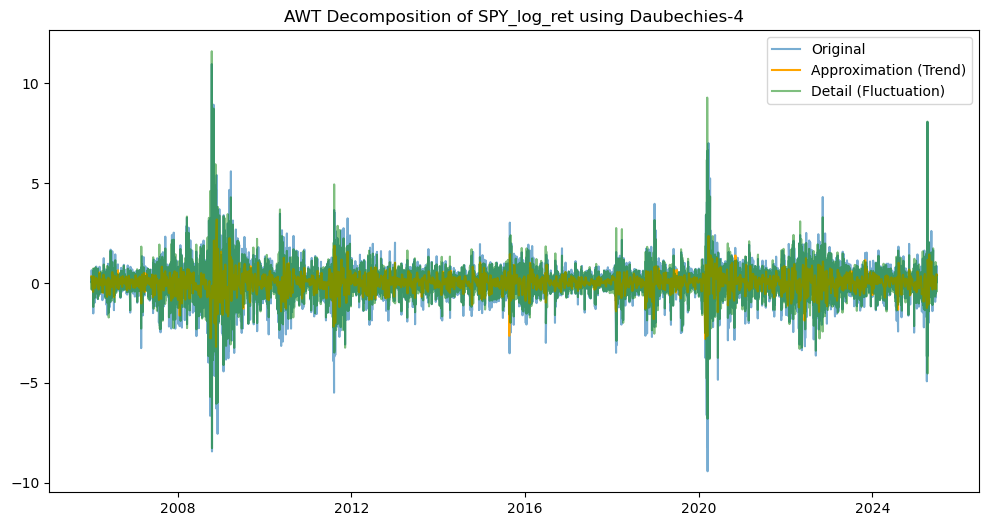


✅ AWT decomposition complete. Data saved as '03_awt_decomposed_data.csv'


In [159]:
#Import required libraries 
import pywt
import matplotlib.pyplot as plt

#1. Extract target signal
signal = df_scaled['SPY_log_ret'].values  # denoised target variable

#2. Choose wavelet parameters
wavelet = 'db4'         # Daubechies 4 is widely used in financial time series
level = 2               # decomposition level (2–4 typical for daily data)

#3. Perform discrete wavelet decomposition
coeffs = pywt.wavedec(signal, wavelet, level=level)

# where coeffs[0] = Approximation (trend), and
# coeffs[1:] = Detail coefficients (short-term fluctuations)

#4. Reconstruct the approximation and detail signals
approximation = pywt.waverec([coeffs[0]] + [None]*level, wavelet)
detail = signal - approximation[:len(signal)]  # ensure same length

# Clip both to the same index as df_scaled
approximation = approximation[:len(df_scaled)]
detail = detail[:len(df_scaled)]

#5. Add components to your DataFrame
df_scaled['SPY_s'] = approximation
df_scaled['SPY_d'] = detail

#6. Visual check of output
plt.figure(figsize=(12,6))
plt.plot(df_scaled.index, df_scaled['SPY_log_ret'], label='Original', alpha=0.6)
plt.plot(df_scaled.index, df_scaled['SPY_s'], label='Approximation (Trend)', color='orange')
plt.plot(df_scaled.index, df_scaled['SPY_d'], label='Detail (Fluctuation)', color='green', alpha=0.5)
plt.legend()
plt.title("AWT Decomposition of SPY_log_ret using Daubechies-4")
plt.show()

#7. Save the decomposed dataset
df_scaled.to_csv("03_awt_decomposed_data.csv")
print("\n✅ AWT decomposition complete. Data saved as '03_awt_decomposed_data.csv'")

# Feature Engineering: 21 Financial Technical Indicators

In [174]:
# ================================================================
# DATA PREPARATION & MERGE (for yfinance-style Data)
# ================================================================

#Import required libraries
import re
import ta  # technical analysis library

# --- 1️⃣ Flatten MultiIndex columns if any ---
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join([str(c) for c in col if c]) for col in df.columns]
    df.columns = [str(c).strip() for c in df.columns]
    return df

df_spx_full = flatten_columns(df_spx_full)
df_scaled = flatten_columns(df_scaled)

# --- 2️⃣ Identify & rename likely OHLCV columns ---
ohlcv_candidates = [c for c in df_spx_full.columns if any(x in c.lower() for x in ['open', 'high', 'low', 'close', 'volume'])]
rename_map = {}
for col in ohlcv_candidates:
    lc = col.lower()
    if 'open' in lc: rename_map[col] = 'SPY_Open'
    elif 'high' in lc: rename_map[col] = 'SPY_High'
    elif 'low' in lc: rename_map[col] = 'SPY_Low'
    elif 'close' in lc and 'adj' not in lc: rename_map[col] = 'SPY_Close'
    elif 'adj' in lc and 'close' in lc: rename_map[col] = 'SPY_Adj_Close'
    elif 'volume' in lc: rename_map[col] = 'SPY_Volume'

df_spx_full = df_spx_full.rename(columns=rename_map)

# --- 3️⃣ Drop duplicates and merge safely ---
df_scaled = df_scaled.drop(columns=[c for c in ['SPY_Close'] if c in df_scaled.columns], errors='ignore')
df_feat = df_scaled.join(
    df_spx_full[[c for c in ['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume'] if c in df_spx_full.columns]],
    how='inner',
    rsuffix='_orig'
)

# --- 4️⃣ Clean up any whitespace or weird naming ---
df_feat.columns = df_feat.columns.map(lambda x: re.sub(r'\s+', '', str(x)))

# --- 5️⃣ Confirm required columns exist ---
required_cols = ['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume']
missing = [c for c in required_cols if c not in df_feat.columns]
if missing:
    raise KeyError(f"Missing SPY OHLCV columns: {missing}")
else:
    print("✅ All SPY OHLCV columns present.")

print(f"Final df_feat shape before feature generation: {df_feat.shape}")
print(df_feat.columns.tolist())


✅ All SPY OHLCV columns present.
Final df_feat shape before feature generation: (4895, 15)
['SPY_Close_SPY', 'DXY_Close_DX-Y.NYB', 'WTI_Close_CL=F', 'SPY_log_ret', 'SPY_price_change', 'SPY_p_change', 'DXY_ret', 'WTI_ret', 'SPY_s', 'SPY_d', 'SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume']


In [176]:
# ================================================================
# FEATURE ENGINEERING: 21 TECHNICAL INDICATORS (CLEAN VERSION)
# ================================================================

import pandas as pd
import numpy as np
import ta  # technical analysis library

# ------------------------------------------------
# 0️⃣ Ensure clean, unique index
# ------------------------------------------------
df_feat = df_feat.copy()
df_feat = df_feat[~df_feat.index.duplicated(keep='first')]
df_feat = df_feat.sort_index()
print(f"✅ Index cleaned. Unique rows: {len(df_feat)}")

# ------------------------------------------------
# 1️⃣ Confirm required columns
# ------------------------------------------------
required_cols = ['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume', 'SPY_s']
for c in required_cols:
    if c not in df_feat.columns:
        raise KeyError(f"Missing required column: {c}")

print("✅ All required columns confirmed present.\n")

# ------------------------------------------------
# 2️⃣ Moving Averages (Trend)
# ------------------------------------------------
price_col = 'SPY_s'
vol_col = 'SPY_Volume'

df_feat['EMA20'] = ta.trend.EMAIndicator(df_feat[price_col], window=20).ema_indicator()
df_feat['MA5'] = ta.trend.SMAIndicator(df_feat[price_col], window=5).sma_indicator()
df_feat['MA10'] = ta.trend.SMAIndicator(df_feat[price_col], window=10).sma_indicator()
df_feat['V_MA5'] = ta.trend.SMAIndicator(df_feat[vol_col], window=5).sma_indicator()
df_feat['V_MA10'] = ta.trend.SMAIndicator(df_feat[vol_col], window=10).sma_indicator()

# ------------------------------------------------
# 3️⃣ Momentum Indicators
# ------------------------------------------------
df_feat['MACD'] = ta.trend.MACD(df_feat[price_col]).macd()
df_feat['ROC'] = ta.momentum.ROCIndicator(df_feat[price_col], window=10).roc()
df_feat['MTM6'] = df_feat[price_col] / df_feat[price_col].shift(126) - 1
df_feat['MTM12'] = df_feat[price_col] / df_feat[price_col].shift(252) - 1

stoch = ta.momentum.StochasticOscillator(
    high=df_feat['SPY_High'],
    low=df_feat['SPY_Low'],
    close=df_feat[price_col],
    window=14,
    smooth_window=3
)
df_feat['SMI'] = stoch.stoch_signal()

# ------------------------------------------------
# 4️⃣ Volatility & Pattern Indicators
# ------------------------------------------------
df_feat['ATR'] = ta.volatility.AverageTrueRange(
    high=df_feat['SPY_High'],
    low=df_feat['SPY_Low'],
    close=df_feat[price_col],
    window=14
).average_true_range()

boll = ta.volatility.BollingerBands(df_feat[price_col], window=20, window_dev=2)
df_feat['BOLL_upper'] = boll.bollinger_hband()
df_feat['BOLL_lower'] = boll.bollinger_lband()
df_feat['BOLL_bandwidth'] = df_feat['BOLL_upper'] - df_feat['BOLL_lower']

df_feat['CCI'] = ta.trend.CCIIndicator(
    high=df_feat['SPY_High'],
    low=df_feat['SPY_Low'],
    close=df_feat[price_col],
    window=20
).cci()

# ------------------------------------------------
# 5️⃣ Volume-based Indicator (WVAD)
# ------------------------------------------------
# Ensure alignment and valid numeric dtype
for c in ['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume']:
    df_feat[c] = pd.to_numeric(df_feat[c], errors='coerce')

df_feat['WVAD'] = (
    (df_feat['SPY_Close'] - df_feat['SPY_Open']) /
    (df_feat['SPY_High'] - df_feat['SPY_Low'] + 1e-10)
) * df_feat['SPY_Volume']

# ------------------------------------------------
# 6️⃣ Final Cleanup
# ------------------------------------------------
df_feat = df_feat.replace([np.inf, -np.inf], np.nan).dropna()
print(f"✅ Technical indicators successfully generated! Final shape: {df_feat.shape}")

# ------------------------------------------------
# 7️⃣ Save to file
# ------------------------------------------------
df_feat.to_csv("04_feature_engineered_data.csv")
print("💾 Saved as '04_feature_engineered_data.csv'")


✅ Index cleaned. Unique rows: 4895
✅ All required columns confirmed present.

✅ Technical indicators successfully generated! Final shape: (4643, 31)
💾 Saved as '04_feature_engineered_data.csv'


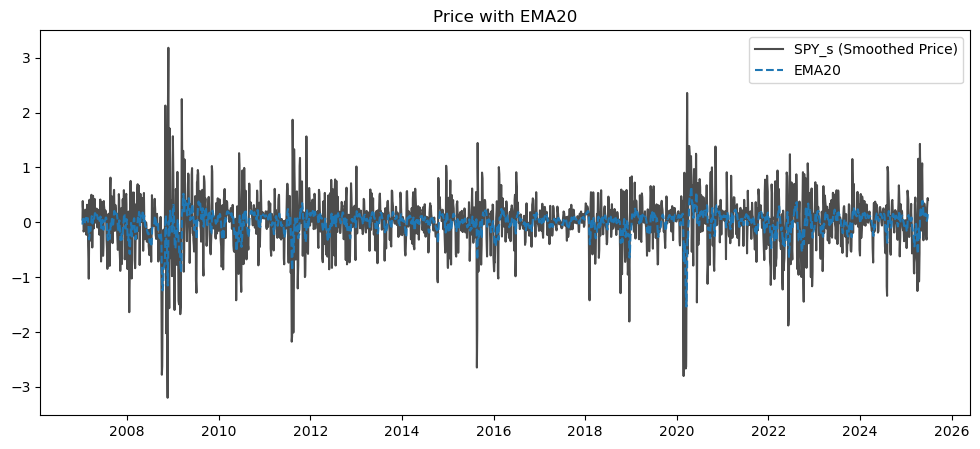

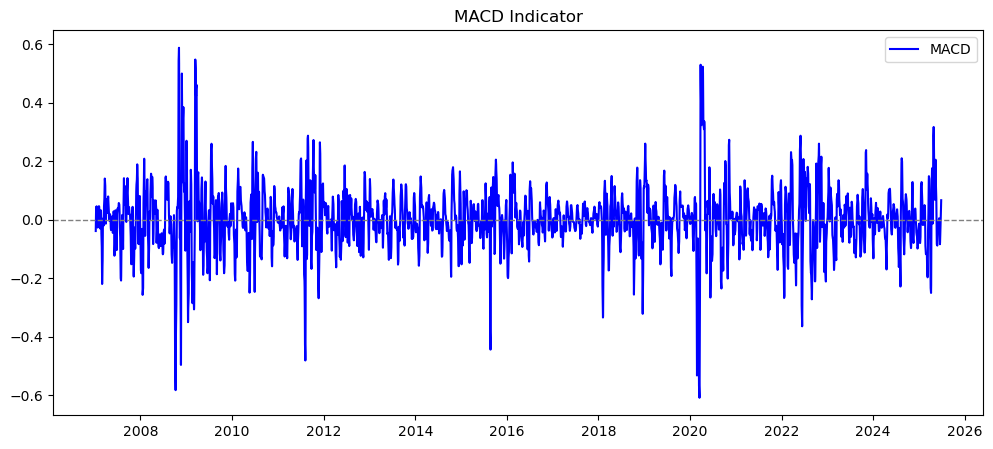

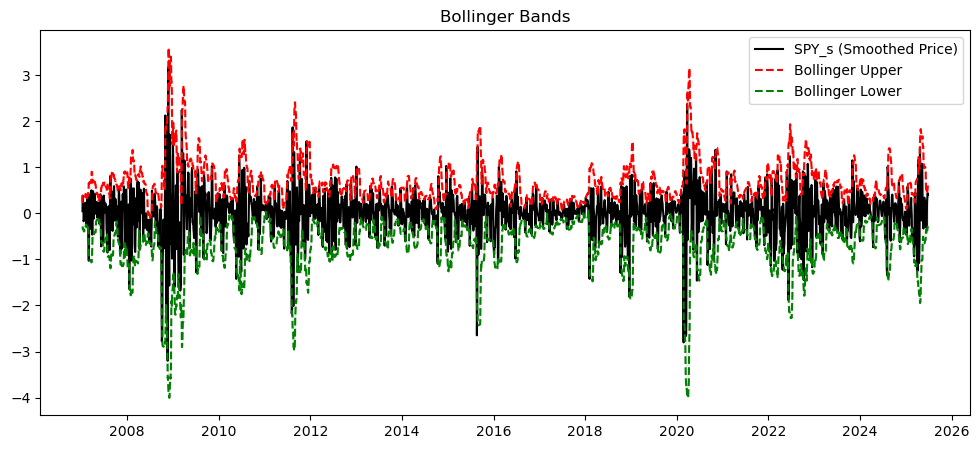

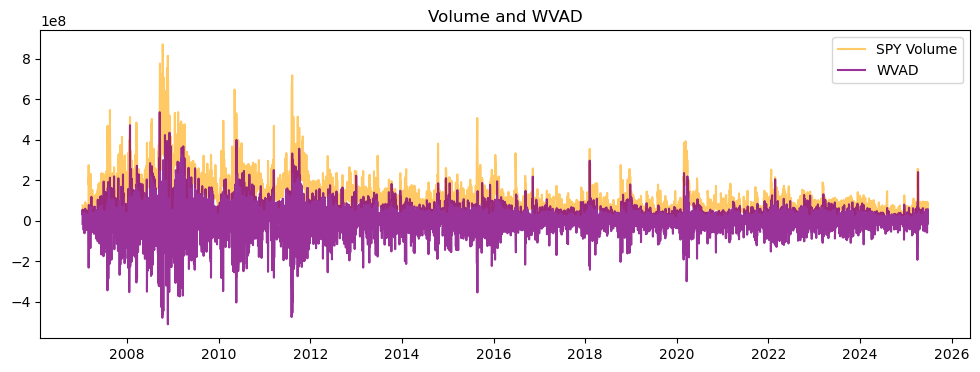

In [178]:
# ================================================================
# 3️⃣ OPTIONAL VISUAL CHECKS
# ================================================================

# --- Plot MACD ---
plt.figure(figsize=(12, 5))
plt.plot(df_feat.index, df_feat[price_col], label='SPY_s (Smoothed Price)', color='black', alpha=0.7)
plt.plot(df_feat.index, df_feat['EMA20'], label='EMA20', linestyle='--')
plt.title("Price with EMA20")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_feat.index, df_feat['MACD'], label='MACD', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("MACD Indicator")
plt.legend()
plt.show()

# --- Plot Bollinger Bands ---
plt.figure(figsize=(12, 5))
plt.plot(df_feat.index, df_feat[price_col], label='SPY_s (Smoothed Price)', color='black')
plt.plot(df_feat.index, df_feat['BOLL_upper'], label='Bollinger Upper', linestyle='--', color='red')
plt.plot(df_feat.index, df_feat['BOLL_lower'], label='Bollinger Lower', linestyle='--', color='green')
plt.fill_between(df_feat.index, df_feat['BOLL_lower'], df_feat['BOLL_upper'], color='gray', alpha=0.1)
plt.title("Bollinger Bands")
plt.legend()
plt.show()

# --- Plot Volume & WVAD ---
plt.figure(figsize=(12, 4))
plt.plot(df_feat.index, df_feat['SPY_Volume'], label='SPY Volume', color='orange', alpha=0.6)
plt.plot(df_feat.index, df_feat['WVAD'], label='WVAD', color='purple', alpha=0.8)
plt.title("Volume and WVAD")
plt.legend()
plt.show()